In [1]:
import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARMA
register_matplotlib_converters()
from time import time
from dateutil.relativedelta import relativedelta

In [2]:
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=DESKTOP-KG95CHB;'
                      'Database=orange_DW__;'
                      'Trusted_Connection=yes;')

In [3]:
print("Connection Successful",conn)

Connection Successful <pyodbc.Connection object at 0x0000029108E39920>


In [4]:
sql_query = pd.read_sql('SELECT Total_final,DIM_Date_id FROM fact_table_data', conn)

In [5]:
sql_query['Total_final']=sql_query['Total_final'].astype(str)
sql_query['DIM_Date_id']= pd.to_datetime(sql_query['DIM_Date_id'])

In [6]:
sql_query['Total_final']=sql_query['Total_final'].fillna(0)
sql_query['Total_final']=sql_query['Total_final'].str.replace('-', "")
sql_query['Total_final']=sql_query['Total_final'].str.replace('nan', "0")

In [7]:
sql_query=sql_query.sort_values(by="DIM_Date_id")

In [8]:
sql_query

,Total_final,DIM_Date_id
7872,0.0,2019-07-08
7871,10.0,2019-07-08
4741,0.0,2019-08-29
4740,1850.0,2019-08-29
4704,1752.0,2019-09-03
...,...,...
12609,0.0,2022-05-12
12610,0.0,2022-05-12
12611,1610.0,2022-05-12
12613,0.0,2022-05-12


In [9]:
sql_query['Total_final']=pd.to_numeric(sql_query['Total_final'])

In [10]:
sql_query['DIM_Date_id']=  sql_query['DIM_Date_id'].dt.to_period('M')

In [11]:
sql_query

,Total_final,DIM_Date_id
7872,0.000,2019-07
7871,10.000,2019-07
4741,0.000,2019-08
4740,1850.000,2019-08
4704,1752.000,2019-09
...,...,...
12609,0.000,2022-05
12610,0.000,2022-05
12611,1610.000,2022-05
12613,0.000,2022-05


In [12]:
firstdate=sql_query.iloc[0,-1]

In [13]:
last_date_prem=sql_query.iloc[-1,-1]

In [14]:
for i in range(12):
    lastdate=sql_query.iloc[-1,-1].to_timestamp() + relativedelta(months=1)
    lastdate=lastdate.to_period(freq='M')
    df2 = {'Total_final': 0,'DIM_Date_id': lastdate}
    sql_query= sql_query.append(df2, ignore_index = True)

In [15]:
sql_query1 = sql_query.groupby('DIM_Date_id').sum()

In [16]:
sql_query1

,Total_final
DIM_Date_id,
2019-07,10.000000
2019-08,1850.000000
2019-09,12634.750031
2019-10,74679.430016
2019-11,9272.250015
2019-12,133750.524940
2020-01,3460.100006
2020-02,9027.549988
2020-03,147491.999954


In [17]:
sql_query1.first_valid_index()

Period('2019-07', 'M')

In [18]:
sql_query1.last_valid_index()

Period('2023-05', 'M')

In [19]:
sql_query1.index = sql_query1.index.to_timestamp()

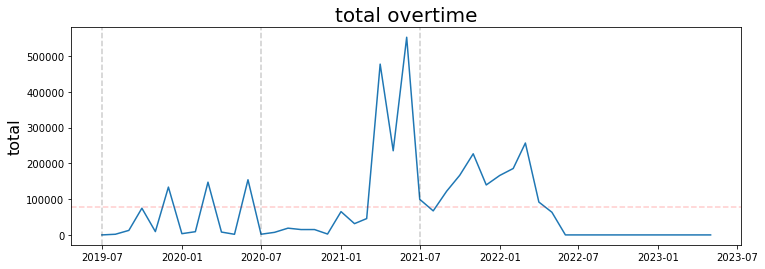

In [20]:
plt.figure(figsize=(12,4))
plt.plot(sql_query1['Total_final'])
plt.title('total overtime',fontsize=20)
plt.ylabel('total',fontsize=16)
for year in range(firstdate.year,last_date_prem.year):
    plt.axvline(pd.to_datetime(str(year)+'-07'), color='k', linestyle='--', alpha=0.2)
plt.axhline(sql_query1['Total_final'].mean(), color='r', alpha=0.2, linestyle='--')

In [21]:
train_end=pd.to_datetime(last_date_prem.to_timestamp())
test_end=pd.to_datetime(lastdate.to_timestamp())
train_data=sql_query1[:train_end]
test_data=sql_query1[train_end + timedelta(days=1):test_end]

In [22]:
train_end + relativedelta(months=1)

Timestamp('2022-06-01 00:00:00')

In [23]:
model=ARMA(train_data,order=(0,4))

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [24]:
predictions_rolling=pd.Series()
for end_date in test_data.index:
    train_data=sql_query1[:end_date - timedelta(days=1)]
    model=ARMA(train_data,order=(0,4))
    model_fit=model.fit()
    pred=model_fit.predict(end_date)
    predictions_rolling.loc[end_date]=pred.loc[end_date]

<ipython-input-24-ae90833914e6>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions_rolling=pd.Series()


In [25]:
predictions_rolling

2022-06-01    24752.702075
2022-07-01    47483.318267
2022-08-01    85564.613820
2022-09-01    53259.802215
2022-10-01    32395.605442
2022-11-01    52804.892794
2022-12-01    61098.628262
2023-01-01    42624.716185
2023-02-01    35877.064692
2023-03-01    47156.780466
2023-04-01    47200.702728
2023-05-01    37310.104083
dtype: float64

In [26]:
predictions_rolling[1]

47483.31826728819

In [27]:
predictions_rolling.size

12

In [28]:
cpt=0
i=0
for index, values in sql_query1.iterrows():
    if(index==last_date_prem.to_timestamp()):
        cpt=1
    elif cpt==1:
        if (i<=predictions_rolling.size):
            sql_query1.loc[index]=predictions_rolling[i]
            i=i+1
        

In [29]:
sql_query1

,Total_final
DIM_Date_id,
2019-07-01,10.000000
2019-08-01,1850.000000
2019-09-01,12634.750031
2019-10-01,74679.430016
2019-11-01,9272.250015
2019-12-01,133750.524940
2020-01-01,3460.100006
2020-02-01,9027.549988
2020-03-01,147491.999954


In [30]:
#sql_query1.loc['2022-05-01']

In [31]:
#last_date_prem.to_timestamp()

In [32]:
#sql_query1.loc['2023-05-01']

In [33]:
#sql_query1.loc['2023-05-01']=1

In [34]:
#sql_query1

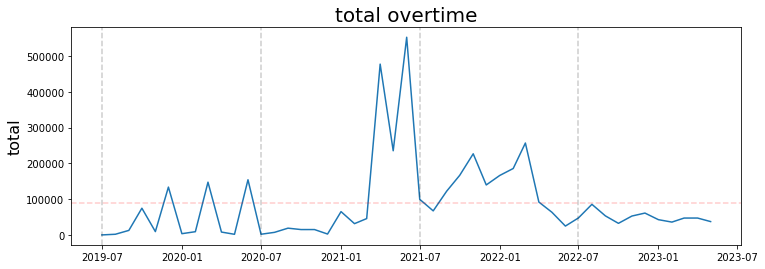

In [35]:
plt.figure(figsize=(12,4))
plt.plot(sql_query1['Total_final'])
plt.title('total overtime',fontsize=20)
plt.ylabel('total',fontsize=16)
for year in range(firstdate.year,lastdate.year):
    plt.axvline(pd.to_datetime(str(year)+'-07'), color='k', linestyle='--', alpha=0.2)
plt.axhline(sql_query1['Total_final'].mean(), color='r', alpha=0.2, linestyle='--')